# Stat project 7
В этом занятии вам предстоит продолжить пример с лекции и протестировать несколько других гипотез.

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

## Вопросы для проверки:
1. Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)
2. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)
3. Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)
Перед проведением тестов проверьте распределения переменных, а также удовлетворяются ли параметрические условия. В зависимости от этого выберите правильный метод (схема выбора – здесь). Возможно пригодятся:

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal

import statsmodels.api as sa 

import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 

## Описание данных
- city – город
- phone – основное устройство, которое использует водитель
- signup_date – дата регистрации аккаунта (YYYYMMDD)
- last_trip_date – дата последней поездки (YYYYMMDD)
- avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- avg_rating_by_driver – средняя оценка поездок водителем
- avg_rating_of_driver – средняя оценка поездок водителя
- surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- avg_surge – средний множитель всплеска за все поездки этого водителя
- trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- weekday_pct – процент поездок пользователя, совершенных в будние дни

In [2]:
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, kruskal, mannwhitneyu
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
df = pd.read_csv('./churn.csv.')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
#проверю тип данных 
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [5]:
#пропущенные значения
df.isna().sum()


avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [6]:
#подготовка данных
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

# Задание 1
Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [7]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [8]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


In [9]:
#создаем сводную таблицу
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [10]:
#тестируем xи-квадрат
ss.chi2_contingency(pd.crosstab(df.churn, df.city))

Chi2ContingencyResult(statistic=3821.5510225559633, pvalue=0.0, dof=2, expected_freq=array([[10315.89328,  6320.3096 , 14559.79712],
       [ 6218.10672,  3809.6904 ,  8776.20288]]))

In [11]:
#пингвин
pg.chi2_independence(df, 'churn', 'city')

(city           Astapor  King's Landing   Winterfell
 churn                                              
 churn      10315.89328       6320.3096  14559.79712
 not_churn   6218.10672       3809.6904   8776.20288,
 city       Astapor  King's Landing  Winterfell
 churn                                         
 churn        12306            3767       15123
 not_churn     4228            6363        8213,
                  test    lambda         chi2  dof  pval    cramer  power
 0             pearson  1.000000  3821.551023  2.0   0.0  0.276462    1.0
 1        cressie-read  0.666667  3788.042430  2.0   0.0  0.275247    1.0
 2      log-likelihood  0.000000  3767.315031  2.0   0.0  0.274493    1.0
 3       freeman-tukey -0.500000  3791.421829  2.0   0.0  0.275370    1.0
 4  mod-log-likelihood -1.000000  3849.643594  2.0   0.0  0.277476    1.0
 5              neyman -2.000000  4073.406300  2.0   0.0  0.285426    1.0)

**Note:** p-value около нуля. Это значит что категориальные переменные (city, churn) как-то связаны между собой

**Ответ:**
Для проверки этой гипотезы я использую **ХИ-КВАДРАТ**, поскольку переменные: **ОБЕ КАТЕГОРИАЛЬНЫЕ**. Нулевая гипотеза **ОТКЛОНЯЕТСЯ**, поскольку **p-value < 0. 05**. Значит, **ВЗАИМОСВЯЗЬ ЕСТЬ**.

# Задание 2
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [12]:
pg.normality(df, 'days_since_last_trip', 'city', method='normaltest')

,W,pval,normal
city,,,
King's Landing,1470.304819,0.0,False
Astapor,117661.016901,0.0,False
Winterfell,152008.270433,0.0,False


<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

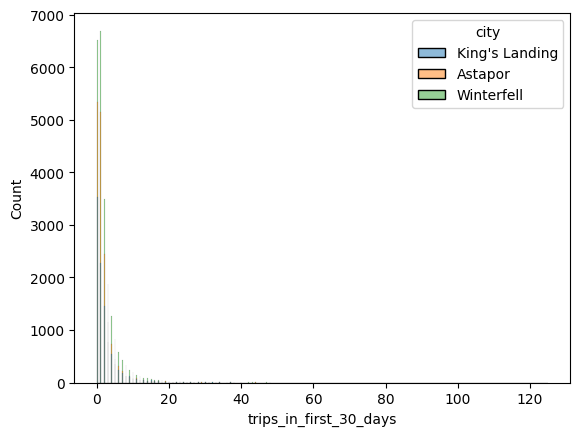

In [13]:
sns.histplot(data=df, x='trips_in_first_30_days', hue='city')

In [14]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

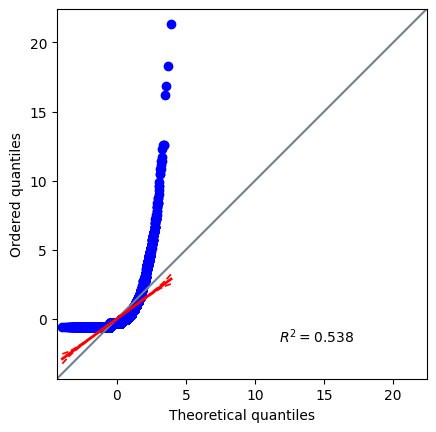

In [15]:
pg.qqplot(df.query("city == 'Astapor'").trips_in_first_30_days)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

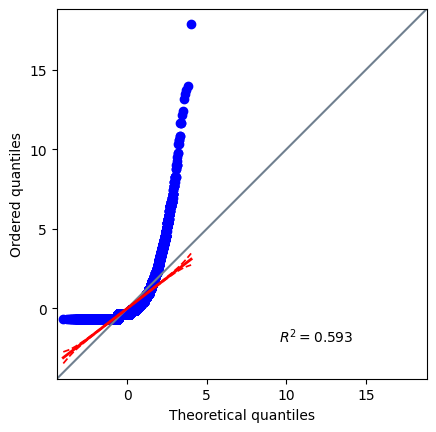

In [16]:
pg.qqplot(df.query("city == 'Winterfell'").trips_in_first_30_days)

In [17]:
df.loc[df.city == "King's Landing", 'city'] = "Kings_Landing"

In [18]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn
0,3.67,5.0,4.7,1.10,Kings_Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,not_churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,churn
3,2.36,4.9,4.6,1.14,Kings_Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,not_churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,churn


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

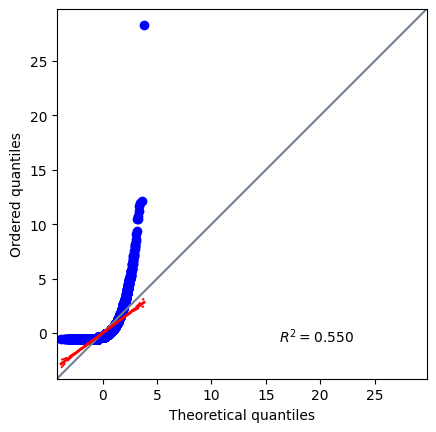

In [19]:
pg.qqplot(df.query("city == 'Kings_Landing'").trips_in_first_30_days)

**Note:**
Распределения не являются нормальными, поэтому используем непараметрический аналог **ANOVA – критерий Краскела-Уоллиса**

# Задание 3
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Обнаружены ли статистически значимые различия?

In [20]:
pg.kruskal(data=df, dv='trips_in_first_30_days', between='city')

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


In [21]:
df.city.unique()

array(['Kings_Landing', 'Astapor', 'Winterfell'], dtype=object)

In [22]:
#второй способ
ss.kruskal(df.query("city == 'Kings_Landing'").trips_in_first_30_days,
           df.query("city == 'Winterfell'").trips_in_first_30_days,
           df.query("city == 'Astapor'").trips_in_first_30_days)

KruskalResult(statistic=221.32105325320535, pvalue=8.72456779180436e-49)

In [23]:
import scikit_posthocs as sp

In [24]:
#попарные сравнения (дополнительно)
sp.posthoc_dunn(a=df, val_col='trips_in_first_30_days', group_col='city', p_adjust='holm')

,Astapor,Kings_Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
Kings_Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


In [25]:
#пингвин
pg.pairwise_ttests(data=df, dv='trips_in_first_30_days', between='city', padjust='bonf', parametric=False)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,city,Astapor,Kings_Landing,False,False,80357689.5,two-sided,9.911753e-09,2.973526e-08,bonf,-0.137636
1,city,Astapor,Winterfell,False,False,176380612.5,two-sided,4.223146e-51,1.266944e-50,bonf,-0.132722
2,city,Kings_Landing,Winterfell,False,False,113477615.0,two-sided,2.459055e-09,7.377165e-09,bonf,0.008143


**Note:**
Статичтически значимо различаются все пары городов
Во всех городах количество поездок в первые 30 дней различаются

<Axes: xlabel='city', ylabel='trips_in_first_30_days'>

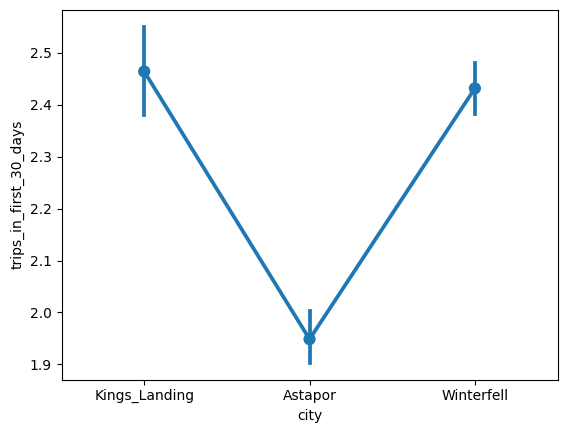

In [26]:
sns.pointplot(data=df, x='city', y='trips_in_first_30_days')

In [27]:
df.groupby('city').trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Astapor,16534.0,1.948651,3.333600,0.0,0.0,1.0,2.0,73.0
Kings_Landing,10130.0,2.463672,4.326140,0.0,0.0,1.0,3.0,125.0
Winterfell,23336.0,2.431179,3.835147,0.0,0.0,1.0,3.0,71.0


# Задание 4
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [29]:
ss.mannwhitneyu(df.query("churn == 'churn'").trips_in_first_30_days,
                df.query("churn == 'not_churn'").trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

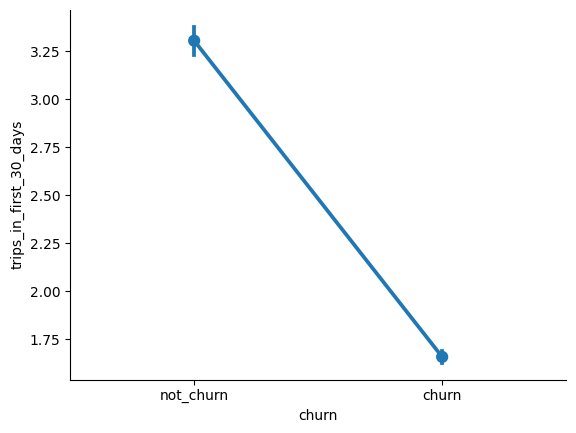

In [30]:
sns.pointplot(x='churn', y='trips_in_first_30_days', data=df)
sns.despine()

In [31]:
df.groupby('churn').trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
churn,31196.0,1.658482,2.654222,0.0,0.0,1.0,2.0,73.0
not_churn,18804.0,3.306318,4.986743,0.0,0.0,2.0,4.0,125.0


**Вывод**
Распределение переменной trips_in_first_30_days **НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ**, поэтому для проверки гипотезы я использую **U-КРИТЕРИЙ МАННА-УИТНИ**. Результат оказался статистически **ЗНАЧИМ**. Значит, **ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ**, **УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ**.